In [2]:
!pip install -q -U google-genai
!pip install pydantic
!pip install seqeval
!pip install google-generativeai

In [3]:
from datasets import load_dataset
import random

# Set the random seed for reproducibility
random.seed(0)
# Load the dataset
dataset = load_dataset("eriktks/conll2003")

# Access the train, validation, and test splits
train_data = dataset["train"]
validation_data = dataset["validation"]
test_data = dataset["test"]

# Print a sample
print(train_data[0])

/Users/francescostella/anaconda3/envs/nlp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7], 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}


In [4]:
# Print a sample from the training data
example = train_data[11001]
print("Example from the training data:")
print(example)
print("Tokens:", example["tokens"])
print("Labels:", example["ner_tags"])

Example from the training data:
{'id': '11001', 'tokens': ['1886', '-', 'At', 'Skeleton', 'Canyon', 'in', 'Arizona', ',', 'Geronimo', ',', 'Apache', 'chief', 'and', 'leader', 'of', 'the', 'last', 'great', 'Red', 'Indian', 'rebellion', 'finally', 'surrendered', 'to', 'General', 'Nelson', 'Miles', '.'], 'pos_tags': [11, 8, 15, 22, 22, 15, 22, 6, 22, 6, 22, 21, 10, 21, 15, 12, 16, 16, 22, 22, 21, 30, 38, 35, 22, 22, 22, 7], 'chunk_tags': [11, 12, 13, 11, 12, 13, 11, 0, 11, 0, 11, 12, 0, 11, 13, 11, 12, 12, 12, 12, 12, 3, 21, 13, 11, 12, 12, 0], 'ner_tags': [0, 0, 0, 5, 6, 0, 5, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 0, 0, 0, 0, 0, 1, 2, 0]}
Tokens: ['1886', '-', 'At', 'Skeleton', 'Canyon', 'in', 'Arizona', ',', 'Geronimo', ',', 'Apache', 'chief', 'and', 'leader', 'of', 'the', 'last', 'great', 'Red', 'Indian', 'rebellion', 'finally', 'surrendered', 'to', 'General', 'Nelson', 'Miles', '.']
Labels: [0, 0, 0, 5, 6, 0, 5, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 0, 0, 0, 0, 0, 1, 2, 0]


In [5]:
print("Training set size:", len(train_data))
print("Validation set size:", len(validation_data))
print("Test set size:", len(test_data))

Training set size: 14041
Validation set size: 3250
Test set size: 3453


{'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}

In [22]:
import csv
import os


def parse_response(tokens : list, response_labels : list, true_labels : list) -> list: 
    '''
    Store the response in a list of lists where the first element is the token, the second element 
    is the predicted label and the third is the true label
    '''
    response_labels = response_labels.split(":")
    response_labels = response_labels[1].strip('\n').split(',')
    if (len(response_labels) != len(tokens)):
        if (len(response_labels) > len(tokens)):
            response_labels = response_labels[:len(tokens)]
        if (len(response_labels) < len(tokens)):
            response_labels = response_labels + ['0'] * (len(tokens) - len(response_labels))

    temp = []
    for i in range(len(tokens)):
        pred_label = int(response_labels[i].strip())
        if(pred_label < 0 or pred_label > 8):
            print(f"Token: {tokens[i]}, Predicted Label: {pred_label}, True Label: {true_labels[i]}")
        #assert (pred_label >= 0 and pred_label <= 8), "Predicted label is out of range"
        temp.append([tokens[i], pred_label, true_labels[i]])

    return temp

def save_to_csv_vanilla(tokens : list, pred_labels : list, true_labels : list, filename : str) -> None:
    file_exists = os.path.isfile(filename)
    # Write header only if the file didn't exist before
    if not file_exists:
        with open(filename, 'a', newline='') as csvfile:
            header = ['token', 'pred', 'true']
            writer = csv.writer(csvfile)
            writer.writerow(header)
    if (len(pred_labels) == 0 and len(true_labels) == 0):
        return
    data = [[tokens[i], pred_labels[i], true_labels[i]] for i in range(len(tokens)) if pred_labels[i] != 0 or true_labels[i] != 0]
    # Remove duplicates
    # Open the file in append mode and write data to analysis purpose
    with open(filename, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(data)

In [6]:
# Take predicted labels and for each token save the label in a list to be used for voting
def store_predicted_labels(pred_labels : list, votes : list) -> None:
    for i in range(len(pred_labels)):
        votes[i].append(pred_labels[i])

In [21]:
# Sample 300 random elements from the test set
sample_train_data = random.sample(list(train_data), 300)
sampled_test_data = random.sample(list(test_data), 300)

In [91]:
import csv
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

label_mapping = {
    0: 'O',
    1: 'B-PER',
    2: 'I-PER',
    3: 'B-ORG',
    4: 'I-ORG',
    5: 'B-LOC',
    6: 'I-LOC',
    7: 'B-MISC',
    8: 'I-MISC'
}

category_to_index = {
    'O': 0,
    'B-PER': 1, 
    'I-PER': 2, 
    'B-ORG': 3, 
    'I-ORG': 4, 
    'B-LOC': 5, 
    'I-LOC': 6, 
    'B-MISC': 7, 
    'I-MISC': 8
    }

valid_labels = set(label_mapping.values())

def evaluate_predictions(filename: str) -> None:
    true_seqs = []
    pred_seqs = []
    current_true = []
    current_pred = []
    invalid_count = 0

    with open(filename, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            true_index = int(row['true'])
            pred_index = int(row['pred'])
            
            true_label = label_mapping.get(true_index, 'O')
            pred_label = label_mapping.get(pred_index, 'INVALID')

            if pred_label not in valid_labels:
                pred_label = 'INVALID'
                invalid_count += 1
                continue

            current_true.append(true_label)
            current_pred.append(pred_label)

        true_seqs.append(current_true)
        pred_seqs.append(current_pred)

    print(f"Invalid predictions: {invalid_count}\n")

    print("Precision:", precision_score(true_seqs, pred_seqs))
    print("Recall:", recall_score(true_seqs, pred_seqs))
    print("F1 Score:", f1_score(true_seqs, pred_seqs))

    print("\nDetailed classification report:\n")
    print(classification_report(true_seqs, pred_seqs))

In [30]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def generate_ner_confusion_matrix_from_csv(file_path):
    """
    Generates and visualizes a confusion matrix for NER data from a CSV file.

    The CSV file is expected to have headers: 'token', 'pred', 'true'.

    Args:
        file_path (str): The path to the CSV file containing the data.

    Returns:
        None: Displays the confusion matrix plot.
    """

    try:
        # Read the CSV file into a pandas DataFrame
        df = pd.read_csv(file_path)

        # Ensure the required columns exist
        if 'pred' not in df.columns or 'true' not in df.columns:
            print("Error: CSV file must contain 'pred' and 'true' columns.")
            return

        # Extract predicted and true label indices
        predicted_indices = df['pred'].tolist()
        true_indices = df['true'].tolist()

        # Convert indices to string labels using the mapping
        predicted_labels_flat = [label_mapping.get(idx, 'UNKNOWN') for idx in predicted_indices]
        true_labels_flat = [label_mapping.get(idx, 'UNKNOWN') for idx in true_indices]

    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return
    except Exception as e:
        print(f"An error occurred while reading the CSV: {e}")
        return

    # Get all unique labels present in the mapping to ensure all classes are in the matrix
    all_possible_labels = sorted(list(label_mapping.values()))

    # Calculate the confusion matrix
    cm = confusion_matrix(true_labels_flat, predicted_labels_flat, labels=all_possible_labels)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=all_possible_labels,
                yticklabels=all_possible_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix for NER Tags')
    plt.show()

In [43]:
import csv
import os

begin_tags = {1,3,5,7}

def parse_response_no_bio(tokens : list, response_labels : list, true_labels : list) -> list: 
    '''
    Store the response in a list of lists where the first element is the token, the second element 
    is the predicted label and the third is the true label
    '''
    response_labels = response_labels.split(":")
    response_labels = response_labels[1].strip('\n').split(',')
    if (len(response_labels) != len(tokens)):
        if (len(response_labels) > len(tokens)):
            response_labels = response_labels[:len(tokens)]
        if (len(response_labels) < len(tokens)):
            response_labels = response_labels + ['0'] * (len(tokens) - len(response_labels))

    temp = []
    for i in range(len(tokens)):
        if i > 0 and temp[i-1][1] in begin_tags and int(response_labels[i].strip()) in begin_tags:
            # If the previous token is a begin tag and this is not '0', we assume it's a continuation
            pred_label = int(response_labels[i].strip()) + 1
        elif i > 0 and int(response_labels[i].strip()) in begin_tags and (temp[i-1][1] - 1) == int(response_labels[i].strip()):
            # if previous token is an inside token and the current is in the same category, we assume it's a continuation
            pred_label = int(response_labels[i].strip()) + 1
        else:
            # Otherwise, we take the label as is
            pred_label = int(response_labels[i].strip())
        if(pred_label < 0 or pred_label > 8):
            print(f"Token: {tokens[i]}, Predicted Label: {pred_label}, True Label: {true_labels[i]}")
        #assert (pred_label >= 0 and pred_label <= 8), "Predicted label is out of range"
        temp.append([tokens[i], pred_label, true_labels[i]])

    return temp

In [25]:
for i in range(5):
    print(sample_train_data[i])

{'id': '2622', 'tokens': ['The', 'company', 'was', 'formed', 'this', 'year', 'and', 'a', 'couple', 'of', 'analysts', 'have', 'been', 'on', 'their', 'properties', ',', 'said', 'one', 'analyst', '.'], 'pos_tags': [12, 21, 38, 40, 12, 21, 10, 12, 21, 15, 24, 41, 40, 15, 29, 24, 6, 38, 11, 21, 7], 'chunk_tags': [11, 12, 21, 22, 11, 12, 0, 11, 12, 13, 11, 21, 22, 13, 11, 12, 0, 21, 11, 12, 0], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
{'id': '3922', 'tokens': ['Antwerp', '1', 'Lommel', '4'], 'pos_tags': [22, 11, 22, 11], 'chunk_tags': [11, 12, 12, 12], 'ner_tags': [3, 0, 3, 0]}
{'id': '3655', 'tokens': ['Liverpool', '0', 'Sunderland', '0'], 'pos_tags': [22, 11, 22, 11], 'chunk_tags': [11, 12, 12, 12], 'ner_tags': [3, 0, 3, 0]}
{'id': '10443', 'tokens': ['WESTERN', 'DIVISION'], 'pos_tags': [22, 22], 'chunk_tags': [11, 12], 'ner_tags': [7, 8]}
{'id': '7342', 'tokens': ['In', 'Kragujevac', 'where', 'the', 'plant', 'is', 'based', ',', '9,000', 'to', '10,000', 

### Vanilla Method

In [81]:
from google import genai
import time

for j in range(len(sample_train_data)):
    # Extract tokens and true labels
    tokens = sample_train_data[j]['tokens']
    true_labels = sample_train_data[j]['ner_tags']
    model = "gemma-3-27b-it"
    #model = 'gemini-2.5-flash-preview-04-17'
    client = genai.Client(api_key=os.getenv("GEMINI_API_KEY"))
    content = f"""Given the following NER tags: {{'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}}, determine the Named Entity Recognition (NER) tags for the following sentence.
            The sentence is: '{tokens}'
            This sentence contains exactly {len(tokens)} tokens.

            Print only the number associated with the NER tag for each of the {len(tokens)} tokens, using the tag-to-number mapping provided above.
            Your answer MUST follow the format: ner_tags: 0, 1, 2, 0, 0, 0
            The number of output NER tags MUST be exactly {len(tokens)}, one for each token in the order they appear in the sentence.
            Do not include any other text or explanations.
            """
    # Send request 
    try:
        response = client.models.generate_content(
            model=model,
            contents=content
        )
        time.sleep(2)

    except Exception as e:
        time.sleep(5)
        response = client.models.generate_content(
            model=model,
            contents=content
        )

    # Parse the response
    data = parse_response(tokens, response.text, true_labels)

    save_to_csv_vanilla(tokens, [item[1] for item in data], true_labels, "data_train_gemma/vanilla_test_bio.csv")

KeyboardInterrupt: 

In [85]:
evaluate_predictions("data_train_gemma/vanilla_test_bio.csv")

Invalid predictions: 0

Precision: 0.49489795918367346
Recall: 0.5689149560117303
F1 Score: 0.529331514324693

Detailed classification report:

              precision    recall  f1-score   support

         LOC       0.46      0.78      0.57        91
        MISC       0.41      0.29      0.34        58
         ORG       0.38      0.29      0.33        79
         PER       0.61      0.73      0.67       113

   micro avg       0.49      0.57      0.53       341
   macro avg       0.47      0.52      0.48       341
weighted avg       0.48      0.57      0.51       341



### Decomposed-QA

In [ ]:
#Decomposed-QA
import google.generativeai as genai
import os
import time

def save_to_csv_qa(pred_labels, true_labels_indices, tokens, filename):
    data = []
    
    # Convert true_labels_indices to a dictionary mapping tokens to their true labels
    true_label_dict = {}
    for token, label_idx in zip(tokens, true_labels_indices):
        # Ensure we're using a valid label from label_mapping
        if label_idx in label_mapping:
            true_label_dict[token] = label_mapping[label_idx]
        else:
            print(f"Warning: Unknown label index {label_idx} for token '{token}', defaulting to 'O'")
            true_label_dict[token] = 'O'
    
    # Process each predicted label and their tokens
    for pred_label, tokens_str in pred_labels.items():
        # Skip invalid labels
        if pred_label == 'None' or pred_label not in category_to_index:
            print(f"Warning: Skipping invalid label '{pred_label}'")
            continue
            
        # Split by commas to get individual tokens
        token_list = [t.strip() for t in tokens_str.split(',')]
        
        for token in token_list:
            if not token:  # Skip empty tokens
                continue
                
            # Check if token exists in original tokens
            if token in tokens:
                # Direct match with a single token
                true_label = true_label_dict.get(token, 'O')
                data.append([token, category_to_index[pred_label], category_to_index[true_label]])
            else:
                # This could be a composite token or doesn't exist in our original tokens
                # Try to match with individual tokens from the original list
                matched_tokens = []
                for orig_token in tokens:
                    # Find approximate matches
                    if orig_token.lower() in token.lower() or token.lower() in orig_token.lower():
                        true_label = true_label_dict.get(orig_token, 'O')
                        data.append([orig_token, category_to_index[pred_label], category_to_index[true_label]])
                        matched_tokens.append(orig_token)
                
                # If we still couldn't match it to any original tokens
                if not matched_tokens:
                    # Only add unknown tokens if they look reasonable (not empty, not "None", etc.)
                    if token != "None" and len(token) > 1:
                        #print(f"Warning: Could not match predicted token '{token}' to original tokens")
                        # We'll add it with 'O' as the true label since we can't find it
                        data.append([token, category_to_index[pred_label], category_to_index['O']])
    
    # Process any tokens that weren't in the predictions but have true labels
    for token, true_label in true_label_dict.items():
        if true_label != 'O':  # Only include non-O labels
            # Check if this token was already processed
            token_processed = any(entry[0] == token for entry in data)
            if not token_processed:
                data.append([token, category_to_index['O'], category_to_index[true_label]])
    
    # Write to CSV
    file_exists = os.path.isfile(filename)
    if not file_exists:
        with open(filename, 'a', newline='') as csvfile:
            header = ['token', 'pred', 'true']
            writer = csv.writer(csvfile)
            writer.writerow(header)
    with open(filename, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(data)

    #print(f"Data written to {filename}")

# Function to parse model responses and extract predicted labels
def parse_model_response(response_text):
    results = {}
    
    if response_text == 'None':
        return results
        
    # Split by & to get multiple label groups
    answers = response_text.split('&')
    answers = [answer.strip() for answer in answers]
    
    for answer in answers:
        answer = answer.strip()
        
        # Skip empty answers or explicit "None" answers
        if not answer or answer == 'None':
            continue
            
        # Check if we have a proper format with colon
        if ':' in answer:
            parts = answer.split(':', 1)  # Split on first colon only
            label = parts[0].strip()
            
            # Validate the label before adding
            if label not in category_to_index:
                print(f"Warning: Skipping invalid label format: '{label}'")
                continue
                
            # Extract entities (everything after the colon)
            entities = parts[1].strip() if len(parts) > 1 else ""
            
            # Only add if we have non-empty entities
            if entities:
                results[label] = entities
        else:
            print(f"Warning: Invalid format in answer: '{answer}'")
    
    return results


label_groups = [(1, 2), (3, 4), (5, 6), (7, 8)]

genai.configure(api_key=os.getenv("GEMINI_API_KEY"))
#model = genai.GenerativeModel('gemini-2.5-flash-preview-04-17')  # or gemma-3-27b-it
#model = genai.GenerativeModel('gemini-2.0-flash-lite')
model = genai.GenerativeModel('gemma-3-27b-it') 

for j in range(len(sample_train_data)):
    tokens = sample_train_data[j]['tokens']
    true_labels = sample_train_data[j]['ner_tags']
    results = {}
    
    chat = model.start_chat()
    # Send general instructions only at the beginning of the conversation
    intro_message = (
        f"""Given the following NER tags: {{'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}}, determine the Named Entity Recognition (NER) tags for the following sentence.
        If there are multiple tokens for a single category then separate the list of tokens with commas.
        
        The sentence is: '{tokens}'.
        This sentence contains exactly {len(tokens)} tokens.
        Remember that a token can only be classified once."""
    )
    # Send message to the chat
    try:
        chat.send_message(intro_message)
        time.sleep(5)
    except Exception as e:
        # If the request fails, try again after 30 seconds to avoid rate limits
        time.sleep(30)
        chat.send_message(intro_message)

    # Send a question for each label group in BIO format
    for group in label_groups:
        label_1 = label_mapping[group[0]]
        label_2 = label_mapping[group[1]]
        prompt = (
            f"""Which are the tokens labeled as '{label_1}' and '{label_2}' in the text? 
            If there are multiple tokens for a single category then separate the list of tokens with commas.
            The output must be in the format: 'B-PER: entity1, entity2, entity3' & 'I-PER: entity4, entity5'.
            If only one category is present, then the output should be: 'B-PER: entity1, entity2, entity3' or 'I-PER: entity4, entity5'.
            If both categories have no entities, just answer with 'None'."""
        )

        try:
            response = chat.send_message(prompt)
            time.sleep(5)
        except Exception as e:
            time.sleep(30)
            response = chat.send_message(prompt)

        try:
            results.update(parse_model_response(response.text))
        except Exception as e:
            print(f"Error parsing response: {e}")
            continue
     
    # Save result to CSV with ad-hoc functin for Basic Decomposed-QA
    save_to_csv_qa(results, true_labels, tokens, "data_train_gemma/decomposed_qa.csv")

KeyboardInterrupt: 

In [79]:
evaluate_predictions("data_train_gemma/decomposed_qa.csv")

Precision: 0.2914349276974416
Recall: 0.5515789473684211
F1 Score: 0.3813682678311499

Detailed classification report:

              precision    recall  f1-score   support

         LOC       0.38      0.87      0.53       124
        MISC       0.26      0.49      0.34        83
         ORG       0.27      0.34      0.30       119
         PER       0.23      0.48      0.32       149

   micro avg       0.29      0.55      0.38       475
   macro avg       0.29      0.55      0.37       475
weighted avg       0.29      0.55      0.37       475



### CoT

In [44]:
#from google import genai
from google import generativeai as genai
import time

for sentence in range(len(sample_train_data)):
    # Extract tokens and true labels
    tokens = sample_train_data[sentence]['tokens']
    true_labels = sample_train_data[sentence]['ner_tags']
    #model = "gemma-3-27b-it"
    genai.configure(api_key=os.getenv("GEMINI_API_KEY"))
    #model = 'gemini-2.5-flash-preview-04-17'
    model = genai.GenerativeModel(model_name="gemma-3-27b-it")
    # Send request 
    time.sleep(3)
    response = model.generate_content(
        contents=f""" Task: Perform Named Entity Recognition (NER) tagging on the sentence below using the BIO tagging scheme.
        Sentence: {tokens}
        Context: You are a world-class linguist and NER expert. I am the CEO of the most influential NER research company, and I’m asking for your highest-quality tagging for this sentence. Consider each token carefully, and use deep contextual understanding. Think through token sequences internally—such as how BIO tags depend on previous tokens—but do not show your reasoning in the output.
        Instructions:
        Use the following tag-to-ID mapping:
        {{'O': 0, 'PERSON': 1, 'ORGANIZATION': 3, 'LOCATION': 5, 'MISCELLANEOUS': 7}}
        Output the corresponding tag ID for each of the {len(tokens)} tokens, in the order they appear.
        Format strictly as: ner_tags: 0, 1, 2, 0, 0, 0 (a comma-separated list of integers).
        The output must contain exactly {len(tokens)} tag IDs — one for each token.
        Do not include any additional commentary, explanation, or formatting beyond the required output.
        Note: Apply internal chain-of-thought reasoning as needed to preserve the logic of the BIO tagging format, particularly for entity continuation (I-) tags. However, do not output any intermediate steps.""",
        generation_config={
        "temperature": 0.2
        # Optionally: "top_k": ..., "top_p": ...
    })
    
    # Parse the response
    data = parse_response_no_bio(tokens, response.text, true_labels)

    save_to_csv_vanilla(tokens, [item[1] for item in data], true_labels, "data_train_gemma/improved_prompt_gemma.csv")

In [78]:
evaluate_predictions("data_train_gemma/improved_prompt_gemma.csv")

Precision: 0.39319727891156464
Recall: 0.560077519379845
F1 Score: 0.46203037569944044

Detailed classification report:

              precision    recall  f1-score   support

         LOC       0.42      0.70      0.52       141
        MISC       0.09      0.18      0.12        85
         ORG       0.39      0.38      0.38       134
         PER       0.65      0.79      0.71       156

   micro avg       0.39      0.56      0.46       516
   macro avg       0.39      0.51      0.43       516
weighted avg       0.43      0.56      0.48       516



### Vanilla NO BIO

In [32]:
from google import genai
import time
import os

for j in range(len(sample_train_data)):
    # Extract tokens and true labels
    tokens = sample_train_data[j]['tokens']
    true_labels = sample_train_data[j]['ner_tags']
    model = "gemma-3-27b-it"
    #model = 'gemini-2.5-flash-preview-04-17'
    client = genai.Client(api_key=os.getenv("GEMINI_API_KEY"))
    content = f"""Given entity label set: {{'O': 0, 'PERSON': 1, 'ORGANIZATION': 3, 'LOCATION': 5, 'MISCELLANEOUS': 7}}.
            Based on the given entity label set, please recognize the named entities in the given text.
            Text: '{tokens}'.
            Your answer MUST follow the format: ner_tags: 0, 1, 0, 5, 5, 0
            The number of output NER tags MUST be exactly {len(tokens)}, one for each token in the order they appear in the sentence.
            Do not include any other text or explanations.
            """
    # Send request 
    try:
        response = client.models.generate_content(
            model=model,
            contents=content
        )
        time.sleep(1)

    except Exception as e:
        time.sleep(5)
        response = client.models.generate_content(
            model=model,
            contents=content
        )

    # Parse the response
    data = parse_response_no_bio(tokens, response.text, true_labels)

    save_to_csv_vanilla(tokens, [item[1] for item in data], true_labels, "data_train_gemma/vanilla_no_bio.csv")

In [77]:
evaluate_predictions("data_train_gemma/vanilla_no_bio.csv")

Precision: 0.43286219081272087
Recall: 0.4748062015503876
F1 Score: 0.45286506469500926

Detailed classification report:

              precision    recall  f1-score   support

         LOC       0.36      0.65      0.46       141
        MISC       0.23      0.21      0.22        85
         ORG       0.44      0.17      0.25       134
         PER       0.61      0.72      0.66       156

   micro avg       0.43      0.47      0.45       516
   macro avg       0.41      0.44      0.40       516
weighted avg       0.44      0.47      0.43       516



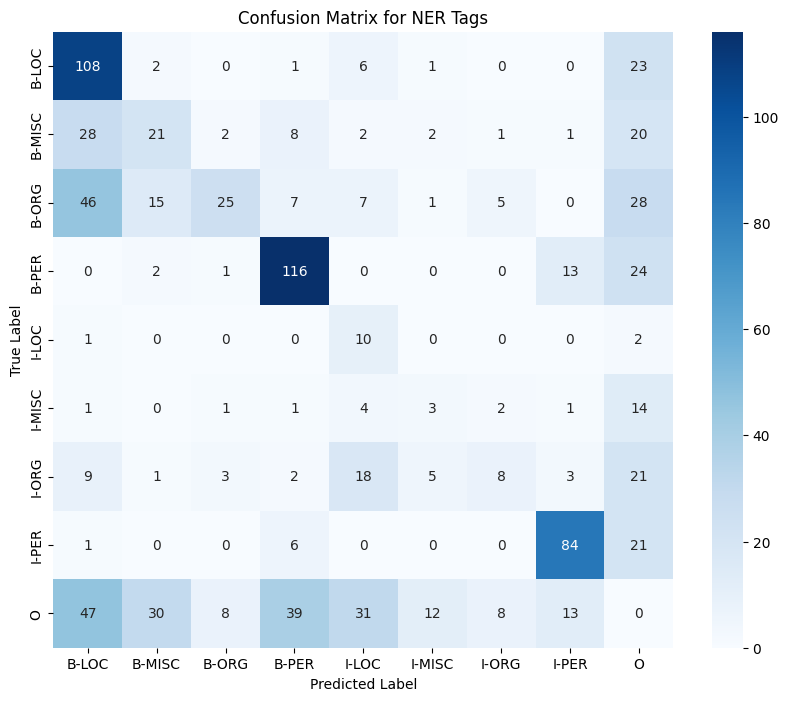

In [76]:
generate_ner_confusion_matrix_from_csv("data_train_gemma/vanilla_no_bio.csv")

### Context aware NER

In [48]:
from google import genai
import time
import os

for j in range(len(sample_train_data)):
#for j in range(100):
    # Extract tokens and true labels
    tokens = sample_train_data[j]['tokens']
    true_labels = sample_train_data[j]['ner_tags']
    model = "gemma-3-27b-it"
    #model = 'gemini-2.5-flash-preview-04-17'
    client = genai.Client(api_key=os.getenv("GEMINI_API_KEY"))
    content = f"""
            Role: you are an expert in Named Entity Recognition (NER) and you are able to recognize entities in a sentence based on context.
            Given the following NER tags: {{'O': 0, 'PERSON': 1, 'ORGANIZATION': 3, 'LOCATION': 5, 'MISCELLANEOUS': 7}}, determine the Named Entity Recognition (NER) tags for the following sentence.
            Entity Type Profiles:
            - PERSON: Names of individuals, titles with names, pronouns referring to people
            - ORGANIZATION: Companies, institutions, government bodies, teams, bands
            - LOCATION: Countries, cities, geographical features, addresses, buildings
            - MISCELLANEOUS: Events, products, languages, nationalities, artworks

            For each token, consider:
            1. What type of entity could this be based on context?
            2. What are the semantic clues around it?
            3. Does it fit the entity profiles above?

            The sentence is: '{tokens}'
            This sentence contains exactly {len(tokens)} tokens.
            Your answer MUST follow the format: ner_tags: 0, 1, 0, 5, 0, 0
            The number of output NER tags MUST be exactly {len(tokens)}, one for each token in the order they appear in the sentence.
            Do not include any other text or explanations.
            """
    # Send request 
    try:
        response = client.models.generate_content(
            model=model,
            contents=content
        )
        time.sleep(1)

    except Exception as e:
        time.sleep(5)
        response = client.models.generate_content(
            model=model,
            contents=content
        )

    # Parse the response
    data = parse_response_no_bio(tokens, response.text, true_labels)

    save_to_csv_vanilla(tokens, [item[1] for item in data], true_labels, "data_train_gemma/context_aware.csv")

In [75]:
evaluate_predictions("data_train_gemma/context_aware.csv")

Precision: 0.41612483745123535
Recall: 0.6201550387596899
F1 Score: 0.49805447470817116

Detailed classification report:

              precision    recall  f1-score   support

         LOC       0.46      0.83      0.59       141
        MISC       0.19      0.40      0.26        85
         ORG       0.36      0.32      0.34       134
         PER       0.58      0.81      0.68       156

   micro avg       0.42      0.62      0.50       516
   macro avg       0.40      0.59      0.47       516
weighted avg       0.43      0.62      0.50       516



### Zero shot with example

In [ ]:
from google import genai
import time
import os

for j in range(len(sample_train_data)):
#for j in range(100):
    # Extract tokens and true labels
    tokens = sample_train_data[j]['tokens']
    true_labels = sample_train_data[j]['ner_tags']
    model = "gemma-3-27b-it"
    #model = 'gemini-2.5-flash-preview-04-17'
    client = genai.Client(api_key=os.getenv("GEMINI_API_KEY"))
    content = f"""You are performing Named Entity Recognition using the following tag IDs:  
    - O: 0  
    - PERSON: 1  
    - ORGANIZATION: 3  
    - LOCATION: 5  
    - MISCELLANEOUS: 7
    Example:  
    Sentence: John works at Microsoft in Seattle  
    Tokens: John, works, at, Microsoft, in, Seattle  
    nertags: 1, 0, 0, 3, 0, 5
    Now analyze this sentence: {tokens}  
    Token count: {len(tokens)}
    Your answer MUST follow the format: ner_tags: 0, 1, 0, 5, 5, 0
    The number of output NER tags MUST be exactly {len(tokens)}, one for each token in the order they appear in the sentence.
    Do not include any other text or explanations.
"""
    # Send request 
    try:
        response = client.models.generate_content(
            model=model,
            contents= content
        )
        time.sleep(1)

    except Exception as e:
        time.sleep(5)
        response = client.models.generate_content(
            model=model,
            contents=content
        )

    # Parse the response
    data = parse_response_no_bio(tokens, response.text, true_labels)

    save_to_csv_vanilla(tokens, [item[1] for item in data], true_labels, "data_train_gemma/zs_example.csv")

KeyboardInterrupt: 

In [ ]:
evaluate_predictions("data_train_gemma/zs_example.csv")

Precision: 0.432475884244373
Recall: 0.556935817805383
F1 Score: 0.48687782805429863

Detailed classification report:

              precision    recall  f1-score   support

         LOC       0.44      0.74      0.55       169
        MISC       0.16      0.49      0.25        43
         ORG       0.40      0.19      0.26       146
         PER       0.67      0.76      0.71       125

   micro avg       0.43      0.56      0.49       483
   macro avg       0.42      0.54      0.44       483
weighted avg       0.46      0.56      0.48       483



In [65]:
from google import genai
import time
import os

for j in range(len(sampled_test_data)):
#for j in range(100):
    # Extract tokens and true labels
    tokens = sampled_test_data[j]['tokens']
    true_labels = sampled_test_data[j]['ner_tags']
    model = "gemma-3-27b-it"
    #model = 'gemini-2.5-flash-preview-04-17'
    client = genai.Client(api_key=os.getenv("GEMINI_API_KEY"))
    content = f"""Assign NER tag IDs to each token in the sentence using this schema:  
                O = 0, PERSON = 1, ORGANIZATION = 3, LOCATION = 5, MISCELLANEOUS = 7
                First: extract the possible tokens from the sentence and then assign the NER tags to each token.
                Second: cretate your POS tags for each token using the Viterbi algorithm and carefully consider the context of the sentence. After that, recontrol the POS tags and make sure they are correct.
                Third: return the NER tags in the following format:
                Your answer MUST follow the format: ner_tags: 0, 1, 0, 5, 5, 0
                The number of output NER tags MUST be exactly {len(tokens)}, one for each token in the order they appear in the sentence.
                Do not include any other text or explanations.
                Sentence: {tokens}  
                Token count: {len(tokens)}
                """
    # Send request 
    try:
        response = client.models.generate_content(
            model=model,
            contents= content
        )
        time.sleep(1)

    except Exception as e:
        time.sleep(5)
        response = client.models.generate_content(
            model=model,
            contents=content
        )

    # Parse the response
    data = parse_response_no_bio(tokens, response.text, true_labels)

    save_to_csv_vanilla(tokens, [item[1] for item in data], true_labels, "data_train_gemma/lite_input_test.csv")

In [73]:
evaluate_predictions("data_train_gemma/lite_input_test.csv")

Precision: 0.37628865979381443
Recall: 0.5714285714285714
F1 Score: 0.45376845376845376

Detailed classification report:

              precision    recall  f1-score   support

         LOC       0.43      0.83      0.57       141
        MISC       0.07      0.19      0.10        57
         ORG       0.32      0.32      0.32       153
         PER       0.58      0.72      0.64       160

   micro avg       0.38      0.57      0.45       511
   macro avg       0.35      0.52      0.41       511
weighted avg       0.41      0.57      0.47       511



### Main Prompt (strict, ID-based output, no explanations)

In [64]:
from google import genai
import time
import os

for j in range(len(sample_train_data)):
#for j in range(100):
    # Extract tokens and true labels
    tokens = sample_train_data[j]['tokens']
    true_labels = sample_train_data[j]['ner_tags']
    model = "gemma-3-27b-it"
    #model = 'gemini-2.5-flash-preview-04-17'
    client = genai.Client(api_key=os.getenv("GEMINI_API_KEY"))
    content = f"""You are an expert in Named Entity Recognition (NER). Your task is to assign an entity tag ID to each token in a sentence, based on the following tag schema:

NER Tag IDs:
- O: 0 (not an entity)
- PERSON: 1 (names of people, personal titles)
- ORGANIZATION: 3 (companies, teams, institutions)
- LOCATION: 5 (cities, countries, landmarks, addresses)
- MISCELLANEOUS: 7 (nationalities, products, events, languages, artworks)

Use only the context to decide if a token refers to one of the entity types. Carefully consider surrounding tokens.

Sentence: {tokens}  
This sentence contains exactly {len(tokens)} tokens.

Your answer MUST follow the format: ner_tags: 0, 1, 0, 5, 5, 0
The number of output NER tags MUST be exactly {len(tokens)}, one for each token in the order they appear in the sentence. Do not include any other text or explanations."""
    # Send request 
    try:
        response = client.models.generate_content(
            model=model,
            contents= content
        )
        time.sleep(1)

    except Exception as e:
        time.sleep(5)
        response = client.models.generate_content(
            model=model,
            contents=content
        )

    # Parse the response
    data = parse_response_no_bio(tokens, response.text, true_labels)

    save_to_csv_vanilla(tokens, [item[1] for item in data], true_labels, "data_train_gemma/context_based_prompt.csv")

In [69]:
evaluate_predictions("data_train_gemma/context_based_prompt.csv")

Precision: 0.4471428571428571
Recall: 0.6065891472868217
F1 Score: 0.5148026315789473

Detailed classification report:

              precision    recall  f1-score   support

         LOC       0.45      0.79      0.58       141
        MISC       0.21      0.40      0.27        85
         ORG       0.40      0.31      0.35       134
         PER       0.68      0.80      0.74       156

   micro avg       0.45      0.61      0.51       516
   macro avg       0.43      0.58      0.48       516
weighted avg       0.47      0.61      0.52       516



### Few shot test

In [61]:
from google import genai
import time
import os

for j in range(len(sample_train_data)):
#for j in range(100):
    # Extract tokens and true labels
    tokens = sample_train_data[j]['tokens']
    true_labels = sample_train_data[j]['ner_tags']
    model = "gemma-3-27b-it"
    #model = 'gemini-2.5-flash-preview-04-17'
    client = genai.Client(api_key=os.getenv("GEMINI_API_KEY"))
    content = f"""You are a Named Entity Recognition (NER) expert. Assign an entity tag ID to each token in the sentence using the schema below.

NER Tag IDs:
- 0 = O: Not an entity
- 1 = PERSON: Specific people or titles with names (e.g., "Barack", "Smith")
- 3 = ORGANIZATION: Named institutions, companies, teams, or agencies (e.g., "Google", "United Nations")
- 5 = LOCATION: Geographical locations or buildings (e.g., "Paris", "Mount Everest", "Empire State Building")
- 7 = MISCELLANEOUS: Nationalities, events, products, languages, works of art (e.g., "Italian", "Olympics", "iPhone", "French")

Warning: Only assign a tag if the token clearly matches an entity type based on context. If unsure, tag as `0 (O)`.

---

Example:

Sentence: Barack Obama visited Microsoft in Seattle.  
Tokens: Barack, Obama, visited, Microsoft, in, Seattle  
ner_tags: 1, 1, 0, 3, 0, 5

---

Now tag the sentence below:

Sentence: {tokens}  
This sentence contains exactly {len(tokens)} tokens.

Your answer MUST follow this format:  
ner_tags: 0, 1, 0, 5, 5, 0  
(Must return exactly {len(tokens)} tag IDs in order, no extra text.)
"""
    # Send request 
    try:
        response = client.models.generate_content(
            model=model,
            contents= content
        )
        time.sleep(1)

    except Exception as e:
        time.sleep(5)
        response = client.models.generate_content(
            model=model,
            contents=content
        )

    # Parse the response
    data = parse_response_no_bio(tokens, response.text, true_labels)

    save_to_csv_vanilla(tokens, [item[1] for item in data], true_labels, "data_train_gemma/few_shot.csv")

In [70]:
evaluate_predictions("data_train_gemma/few_shot.csv")

Precision: 0.4925373134328358
Recall: 0.6395348837209303
F1 Score: 0.5564924114671163

Detailed classification report:

              precision    recall  f1-score   support

         LOC       0.54      0.79      0.64       141
        MISC       0.28      0.60      0.38        85
         ORG       0.45      0.31      0.36       134
         PER       0.67      0.81      0.73       156

   micro avg       0.49      0.64      0.56       516
   macro avg       0.48      0.63      0.53       516
weighted avg       0.51      0.64      0.55       516



### Advanced version

In [36]:
from google import genai
import time
import os

# ---

# Example:
# Sentence: Dr. Jane Smith gave a talk at Google in Berlin.  
# Tokens: Dr., Jane, Smith, gave, a, talk, at, Google, in, Berlin  
# ner_tags: 1, 1, 1, 0, 0, 0, 0, 3, 0, 5


for j in range(len(sample_train_data)):
#for j in range(100):
    # Extract tokens and true labels
    tokens = sample_train_data[j]['tokens']
    true_labels = sample_train_data[j]['ner_tags']
    model = "gemma-3-27b-it"
    #model = 'gemini-2.5-flash-preview-04-17'
    client = genai.Client(api_key=os.getenv("GEMINI_API_KEY"))
    content = f"""You are an expert in Named Entity Recognition (NER). Your task is to assign an entity tag ID to each token in the sentence using the strict schema below.

            NER Tag IDs:
            - 0 = O → Not an entity  
            - 1 = PERSON → Real names, personal titles   
            - 3 = ORGANIZATION → Companies, institutions, teams, agencies 
            - 5 = LOCATION → Cities, countries, natural landmarks, buildings
            - 7 = MISCELLANEOUS → Nationalities, languages, events, products, titles of works 

            ---

            Rules:
            - Use only contextual evidence to determine entity types.
            - If the token does not clearly match a defined type, assign `0 (O)`.
            - Please do not assign tags based on assumptions or incomplete context.
            - Please be as precise as possible

            ---

            Now tag the sentence below:
            Sentence: {tokens}  
            This sentence contains exactly {len(tokens)} tokens.

            Your answer MUST follow this format:  
            ner_tags: 0, 1, 0, 5, 5, 0  
            (Must return exactly {len(tokens)} tag IDs in order, no extra text.)
            """
    # Send request 
    try:
        response = client.models.generate_content(
            model=model,
            contents= content
        )
        time.sleep(1)

    except Exception as e:
        time.sleep(5)
        response = client.models.generate_content(
            model=model,
            contents=content
        )

    # Parse the response
    data = parse_response_no_bio(tokens, response.text, true_labels)

    save_to_csv_vanilla(tokens, [item[1] for item in data], true_labels, "data_train_gemma/precision_enhanced_advanced_no_ex.csv")

In [72]:
evaluate_predictions("data_train_gemma/precision_enhanced_advanced_no_ex.csv")

Precision: 0.5
Recall: 0.627906976744186
F1 Score: 0.5567010309278351

Detailed classification report:

              precision    recall  f1-score   support

         LOC       0.49      0.82      0.62       141
        MISC       0.27      0.39      0.32        85
         ORG       0.41      0.33      0.37       134
         PER       0.72      0.84      0.77       156

   micro avg       0.50      0.63      0.56       516
   macro avg       0.47      0.59      0.52       516
weighted avg       0.50      0.63      0.55       516



### Guided method Luca

In [54]:
from google import genai
import time
import os

for j in range(len(sample_train_data)):
    # Extract tokens and true labels
    tokens = sample_train_data[j]['tokens']
    true_labels = sample_train_data[j]['ner_tags']
    pos_tags = sample_train_data[j]['pos_tags']
    model = "gemma-3-27b-it"
    #model = 'gemini-2.5-flash-preview-04-17'
    client = genai.Client(api_key=os.getenv("GEMINI_API_KEY"))
    content = f"""You are a strict NER tagging system.

    NER Tag IDs:
    - 0 = O → Not an entity  
    - 1 = PERSON → Real names, personal titles   
    - 3 = ORGANIZATION → Companies, institutions, teams, agencies 
    - 5 = LOCATION → Cities, countries, natural landmarks, buildings
    - 7 = MISCELLANEOUS → Nationalities, languages, events, products, titles of works

    Your task is to assign the correct tag number to each token in this sentence:
    {tokens}

    You are also given the POS tag (part-of-speech) for each token.
    POS tags (in order, one per token):
    {pos_tags}

    Respond ONLY with:
    ner_tags: 0, 3, 3, 3, 0, 1, 0, ...  ← (exactly {len(tokens)} integers)

    Do NOT include explanations, thoughts, or any other content.
    Do NOT write anything before or after "ner_tags: ...".
    Just print the sequence in the format specified.
    """
    # Send request 
    try:
        response = client.models.generate_content(
            model=model,
            contents= content
        )
        time.sleep(1)

    except Exception as e:
        time.sleep(5)
        response = client.models.generate_content(
            model=model,
            contents=content
        )

    # Parse the response
    data = parse_response_no_bio(tokens, response.text, true_labels)

    save_to_csv_vanilla(tokens, [item[1] for item in data], true_labels, "data_train_gemma/pos_guided_no_bio_info_class.csv")

Token: Cuban, Predicted Label: 16, True Label: 7
Token: 1991, Predicted Label: 11, True Label: 0


In [88]:
evaluate_predictions("data_train_gemma/pos_guided_no_bio_info_class.csv")

Invalid predictions: 1

Precision: 0.40746054519368724
Recall: 0.5503875968992248
F1 Score: 0.4682605111294311

Detailed classification report:

              precision    recall  f1-score   support

         LOC       0.52      0.74      0.61       141
        MISC       0.20      0.22      0.21        85
         ORG       0.21      0.31      0.25       134
         PER       0.57      0.76      0.65       156

   micro avg       0.41      0.55      0.47       516
   macro avg       0.38      0.51      0.43       516
weighted avg       0.40      0.55      0.46       516



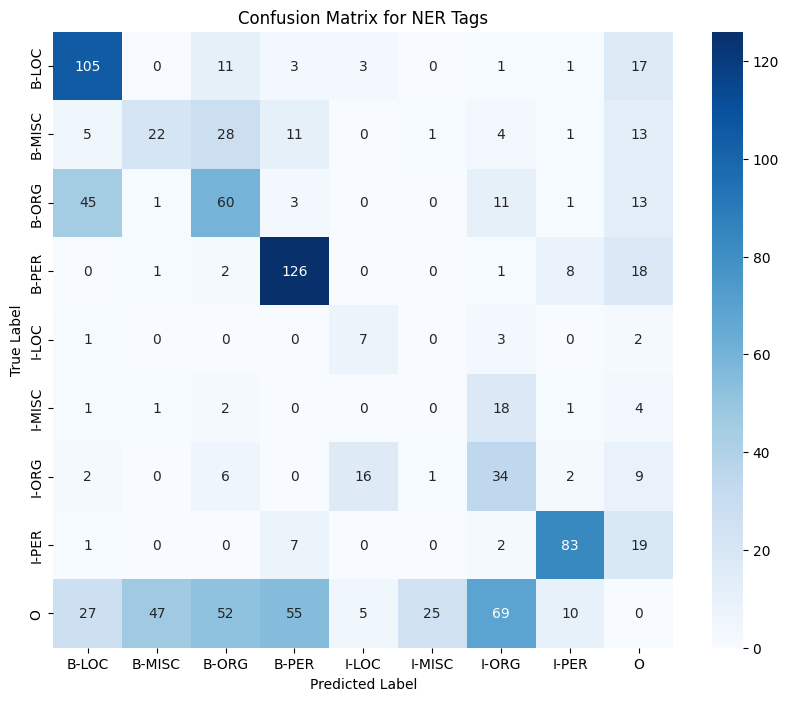

In [90]:
generate_ner_confusion_matrix_from_csv("data_train_gemma/pos_guided_no_bio_info_class.csv")

In [ ]:
from google import genai
import time
import os

for j in range(len(sample_train_data)):
    # Extract tokens and true labels
    tokens = sample_train_data[j]['tokens']
    true_labels = sample_train_data[j]['ner_tags']
    pos_tags = sample_train_data[j]['pos_tags']
    model = "gemma-3-27b-it"
    #model = 'gemini-2.5-flash-preview-04-17'
    client = genai.Client(api_key=os.getenv("GEMINI_API_KEY"))
    content = f"""You are a strict NER tagging system.

    Given the following NER tags:
    {{'O': 0, 'PER': 1, 'ORG': 3, 'LOC': 5, 'MISC': 7}}

    Your task is to assign the correct tag number to each token in this sentence:
    {tokens}

    You are also given the POS tag (part-of-speech) for each token.
    POS tags (in order, one per token):
    {pos_tags}

    Respond ONLY with:
    ner_tags: x, x, x, ..., x  ← (exactly {len(tokens)} integers)

    Do NOT include explanations, thoughts, or any other content.
    Do NOT write anything before or after "ner_tags: ...".
    Just print the sequence in the format specified.
    """
    # Send request 
    try:
        response = client.models.generate_content(
            model=model,
            contents= content
        )
        time.sleep(1)

    except Exception as e:
        time.sleep(5)
        response = client.models.generate_content(
            model=model,
            contents=content
        )

    # Parse the response
    data = parse_response_no_bio(tokens, response.text, true_labels)

    save_to_csv_vanilla(tokens, [item[1] for item in data], true_labels, "data_train_gemma/pos_guided_no_bio.csv")

In [89]:
evaluate_predictions("data_train_gemma/pos_guided_no_bio.csv")

Invalid predictions: 0

Precision: 0.49846625766871167
Recall: 0.6298449612403101
F1 Score: 0.5565068493150686

Detailed classification report:

              precision    recall  f1-score   support

         LOC       0.54      0.82      0.65       141
        MISC       0.19      0.34      0.25        85
         ORG       0.51      0.35      0.41       134
         PER       0.69      0.85      0.76       156

   micro avg       0.50      0.63      0.56       516
   macro avg       0.48      0.59      0.52       516
weighted avg       0.52      0.63      0.56       516

